# Analyzing the data
So far I'm just playing some randomized samples from each class in the training set, as well as the test sequences, just in order to make it easier to see what we're working with.

## Unzip dataset
In order for this to work, you'll have to access the file called 'building_106_kitchen.zip' (.wav dataset). How you do that is up to you. I uploaded it to my drive and access it from there.

In [1]:
 # run once, also runtime may ask to be restarted, that's fine
 '''
!pip install rockpool
!pip install --upgrade "jax[cpu]"
!pip install jax==0.4.20 jaxlib==0.4.20
!pip install samna
!pip install bitstruct
'''
!pip install torch
!pip install rockpool
!pip install --upgrade jax jaxlib
!pip install samna
!pip install bitstruct
!pip install librosa
!pip install matplotlib
!pip install numpy
!pip install scipy
#!pip install soundfile
#!pip install tqdm
!pip install torchvision
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 550.7/550.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rockpool: filename=rockpool-3.0.3-py3-none-any.whl size=675907 sha256=ee85626f67b2da272d5bb93307d606991e49a9f5e99d8038d46ed2f837e32464
  Stored in directory: /root/.cache/pip/wheels/e3/7c/bf/49b9bd3b69f317c2ed76c1c6d05102995500b7433416de6665
Successfully built rockpool
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.2
    Uninstalling jaxlib-0.7.2:
      Successfully uninstalled jaxlib-0.7.2
  Attempting uninstall: jax
    Found existing installation: jax 0.7.2
    Uninstalling jax-0.7.2:
      Successfully uninstalled jax-0.7.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 1.7 MB/s eta 0:00:00


In [2]:
from zipfile import ZipFile
import os
from IPython.display import Image, Audio, display
import numpy as np
import scipy as sp
import librosa
import random
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm
import gc

from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.timeseries import TimeSeries, TSContinuous
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from rockpool.nn.modules import LIFTorch, LinearTorch, ExpSynTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from rockpool.utilities.backend_management import backend_available

In [3]:
import os
os.chdir('/')
!ls /content/drive/MyDrive/D7046E_SNN_project_dataset

ls: cannot access '/content/drive/MyDrive/D7046E_SNN_project_dataset': No such file or directory


In [4]:
# run this if you upload to drive
from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/building_106_kitchen.zip'
extract_path = '/content/dataset'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [5]:
zip_file_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/kitchen_spike_dataset.zip'
extract_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [6]:
# run this if you upload to colab directly
#zip_file_path = '/content/building_106_kitchen.zip'
#extract_path = '/content/dataset'

#with ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_path)

## Play sample from each training class


In [ ]:

# path to each training class
train_segments_path = '/content/dataset/building_106_kitchen/training_segments'
class_directories = []
for item in os.listdir(train_segments_path):
    item_path = os.path.join(train_segments_path, item)
    if os.path.isdir(item_path):
        class_directories.append(item)

# one random audio sample from each class
# run this cell again to get different samples
for class_name in class_directories:
    class_path = os.path.join(train_segments_path, class_name)
    wav_files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
    if wav_files:
        random_wav_file = random.choice(wav_files)
        print(f"\nClass: {class_name}")
        display(Audio(os.path.join(class_path, random_wav_file)))
print("we got ", len(class_directories), "classes")


## Play each test sequence

In [ ]:
test_sequence_path = '/content/dataset/building_106_kitchen/test_sequence'
for filename in os.listdir(test_sequence_path):
    if filename.endswith('.wav'):
        file_path = os.path.join(test_sequence_path, filename)
        print(f"\nSequence: {filename}")
        display(Audio(file_path))

# Converting audio data into spike data
I'm likely gonna base this on [this tutorial](https://rockpool.ai/devices/analog-frontend-example.html) from Rockwell documentation on how to convert audio data into spike, though our data is in .wav format so some small extra steps are needed. It seems rockwell wants the audio as a numpy array.

Basically, in the Rockpool library there is AFEsim, a simulation of the analog front-end module of the Xylo Audio 2 device, a piece of neuromorphic hardware, which converts audio frequency bands into spikes. We can use this to convert a .wav file into spike data.

## Convert and plot one sample

In [9]:
# parameters for AFESim
fs = 110e3                          # The sampling frequency of the input, in Hz
raster_period = 10e-3               # The output rasterisation time-step in seconds
max_spike_per_raster_period = 15    # Maximum number of events per output time-step

# set them false for now
add_noise = False                   # Enables / disables simulated noise generated by the AFE
add_offset = False                  # Add mismatch offset to each filter
add_mismatch = False                # Add simualted mismatch to filter parameters
seed = None                         # Seed for mistmatch generation

In [10]:
# should input AFESim and path to .wav file and ouput spike representation
def wav_to_spikes(path, afe):
    audio, sr = librosa.load(path, sr=None, mono=True)
    print(audio)

    # create a time vector for time series object
    times = np.arange(len(audio)) / sr

    # rockpool continuous time series
    ts_audio = TSContinuous(times, audio[:, None])

    # pass through AFESim
    spikes, state, rec = afe(ts_audio)

    return spikes, state, rec


Class: food_processor, File: take17.wav
[-3.9611816e-02 -2.5070190e-02 -5.2642822e-03 ... -1.2847900e-01
 -1.3046265e-01  1.5258789e-05]
Spike format:
<class 'rockpool.timeseries.TSEvent'>


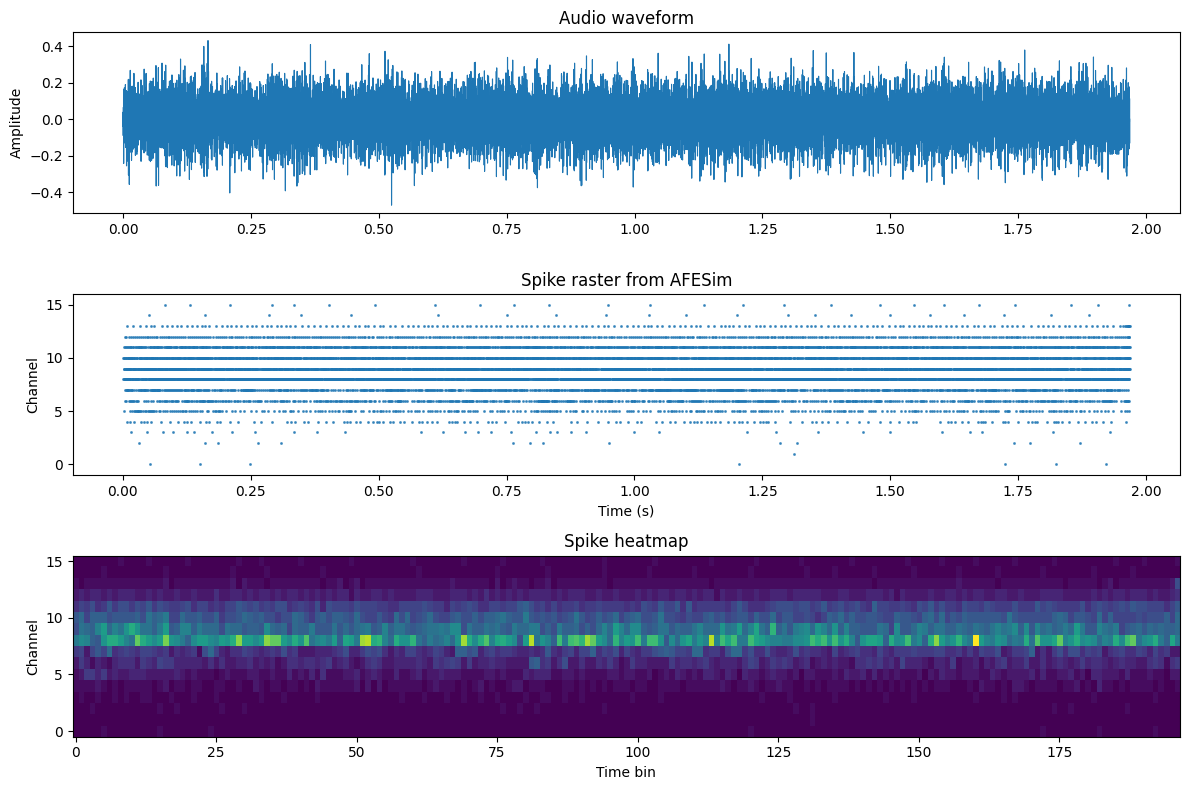

In [11]:
# initialize the AFE simulation
afe = AFESim(
        fs = fs,
        raster_period = raster_period,
        max_spike_per_raster_period = max_spike_per_raster_period,
        add_noise = add_noise,
        add_offset = add_offset,
        add_mismatch = add_mismatch,
        seed = seed,
).timed()

# load one random audio sample
random_class_name = random.choice(class_directories)
random_class_path = os.path.join(train_segments_path, random_class_name)
wav_files_in_random_class = [f for f in os.listdir(random_class_path) if f.endswith('.wav')]
random_audio_file = random.choice(wav_files_in_random_class)

audio_path = os.path.join(random_class_path, random_audio_file)
print(f"Class: {random_class_name}, File: {random_audio_file}")

audio, sr = librosa.load(audio_path, sr=None, mono=True)

# convert to spikes
spike_output, _, _= wav_to_spikes(audio_path, afe)
print("Spike format:")
print(type(spike_output))

spike_times = spike_output.times
spike_channels = spike_output.channels

# listen
display(Audio(audio_path))

# waveform plot
fig, ax = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[1,1,1]})

t_audio = np.arange(len(audio)) / sr
ax[0].plot(t_audio, audio, linewidth=0.8)
ax[0].set_title("Audio waveform")
ax[0].set_ylabel("Amplitude")

# spike raster
ax[1].scatter(spike_times, spike_channels, s=5, marker='.', alpha=0.7)
ax[1].set_title("Spike raster from AFESim")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Channel")
ax[1].set_ylim(-1, 16)     # AFESim uses 16 filterbank channels

raster_matrix = spike_output.raster(dt=10e-3, add_events=True)  # 10 ms bins
ax[2].imshow(raster_matrix.T, aspect="auto", origin="lower")
ax[2].set_xlabel("Time bin")
ax[2].set_ylabel("Channel")
ax[2].set_title("Spike heatmap")

plt.tight_layout()
plt.show()

## Note on plot
We can see here that the AFE simulation has 16 outputs, and this is because of a band-pass filter bank which splits the (audio) signal into 16 bands. The lowest band, index 0, has a centre frequency of 40 and the highest band, index 15, has a centre frequency of 16940, as shown in the code cell just below. I believe we should be able to tune the bands if we wanted to. [AFESim documentation](https://rockpool.ai/reference/_autosummary/devices.xylo.syns61201.AFESim.html) shows a bunch of parameters we might be interested in looking at or even tuning.

In [12]:
print("Center frequencies:", afe.module.fcs)

Center frequencies: [   40.    54.    77.   137.   203.   290.   428.   674.  1177.  1700.
  2226.  3418.  5154.  7884. 11630. 16940.]


## Custom dataset loader
Because we have our own dataset, unlike the tutorial we can't use Tonic to create datloaders, but create a custom dataset class. We also need to convert every single .wav file to a tensor, which is very computationally heavy.

In [13]:
class SpikeRasterDataset(Dataset):
    def __init__(self, sample_info_path, transform=None):
        self.sample_info = np.load(sample_info_path, allow_pickle=True)
        self.transform = transform

    def __len__(self):
        return len(self.sample_info)

    def __getitem__(self, idx):
        spike_path, class_idx = self.sample_info[idx]
        spikes = np.load(spike_path)  # shape (T, C)
        if self.transform is not None:
            spikes = self.transform(spikes)
        # convert to float tensor
        spikes = torch.from_numpy(spikes).float()
        return spikes, class_idx

In [14]:
dataset_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/kitchen_spike_dataset/sample_info.npy'
dataset = SpikeRasterDataset(dataset_path)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print("train set size:\t",train_size)
print("val set size:\t",val_size)
print("test set size:\t",test_size)
print("total size:\t",total_size)

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


import numpy as np
import matplotlib.pyplot as plt

train set size:	 1031
val set size:	 220
test set size:	 222
total size:	 1473


Spike shape: (300, 16)
Label: 1


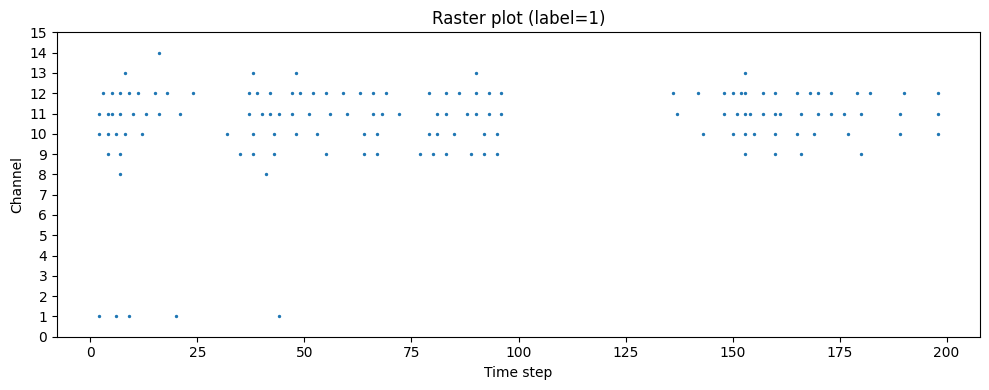

From metadata:
class_to_idx
 background: 0
 bag: 1
 blender: 2
 cornflakes_bowl: 3
 cornflakes_eating: 4
 cup: 5
 dish_washer: 6
 electric_razor: 7
 flatware_sorting: 8
 food_processor: 9
 hair_dryer: 10
 microwave: 11
 microwave_bell: 12
 microwave_door: 13
 plates_sorting: 14
 stirring_cup: 15
 toaster_up_down: 16
 toilet_button: 17
 toilet_flush: 18
 tooth: 19
 vacuum_cleaner: 20
 washing_machine: 21
 water_boiler: 22
 water_tap: 23



In [15]:
# visualize any sample just to make sure it looks ok
import numpy as np
import matplotlib.pyplot as plt

sample_info = np.load(dataset_path, allow_pickle=True)

spike_path, label = sample_info[99]
spikes = np.load(spike_path)

print("Spike shape:", spikes.shape)
print("Label:", label)

def plot_spike_raster(spikes, title=None):
    T, C = spikes.shape

    times = []
    channels = []

    for t in range(T):
        for c in range(C):
            count = int(spikes[t, c])
            if count > 0:
                times.extend([t] * count)
                channels.extend([c] * count)

    plt.figure(figsize=(10, 4))
    plt.scatter(times, channels, s=2)
    plt.xlabel("Time step")
    plt.ylabel("Channel")
    plt.yticks(range(C))
    plt.title(title or "Spike Raster Plot")
    plt.tight_layout()
    plt.show()

plot_spike_raster(spikes, title=f"Raster plot (label={label})")

print("From metadata:\nclass_to_idx\n",
    "background: 0\n",
    "bag: 1\n",
    "blender: 2\n",
    "cornflakes_bowl: 3\n",
    "cornflakes_eating: 4\n",
    "cup: 5\n",
    "dish_washer: 6\n",
    "electric_razor: 7\n",
    "flatware_sorting: 8\n",
    "food_processor: 9\n",
    "hair_dryer: 10\n",
    "microwave: 11\n",
    "microwave_bell: 12\n",
    "microwave_door: 13\n",
    "plates_sorting: 14\n",
    "stirring_cup: 15\n",
    "toaster_up_down: 16\n",
    "toilet_button: 17\n",
    "toilet_flush: 18\n",
    "tooth: 19\n",
    "vacuum_cleaner: 20\n",
    "washing_machine: 21\n",
    "water_boiler: 22\n",
    "water_tap: 23\n"
  )

Note: some of theses files seem to contain no spikes at all. We should consider filtering them out.

# Training algorithm


In [16]:
import torch.nn as nn
from rockpool.nn.modules import LIF

class SimpleAudioNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.proj = nn.Linear(input_dim, 64)
        self.lif = LIF(shape=(64,))
        self.readout = nn.Linear(64, num_classes)

    def forward(self, ts):
        x = torch.as_tensor(ts.samples, dtype=torch.float32)
        x = self.proj(x)
        spk, _ = self.lif(x)
        logits = self.readout(spk)
        return logits.mean(dim=0)


In [17]:
shd_timestep = 1e-6
shd_channels = 16
net_channels = 16
net_dt = 10e-3
sample_T = 300
batch_size = 64
num_workers = 6

from rockpool.nn.modules import LIFTorch, LinearTorch, ExpSynTorch, LIFExodus
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Select a neuron model to use
from rockpool.utilities.backend_management import backend_available
NeuronModel = LIFExodus if backend_available('sinabs-exodus') and torch.cuda.is_available() else LIFTorch

# - Network Definition
def SimpleNet(Nin, Nhidden, Nout):
    return Sequential(
        LinearTorch((Nin, Nhidden), has_bias=False),
        NeuronModel(Nhidden,
            tau_mem=Constant(100e-3),
            tau_syn=Constant(100e-3),
            threshold=Constant(1.),
            bias=Constant(0.),
            dt=net_dt,
            has_rec=False),
        LinearTorch((Nhidden, Nhidden), has_bias=False),
        NeuronModel(Nhidden,
            tau_mem=Constant(100e-3),
            tau_syn=Constant(100e-3),
            threshold=Constant(1.),
            bias=Constant(0.),
            dt=net_dt,
            has_rec=False),
        LinearTorch((Nhidden, Nout), has_bias = False),
        ExpSynTorch(Nout, dt=net_dt, tau=Constant(5e-3))
    )


# - Build a network
Nin = net_channels
Nhidden = 20
Nout = 24

torch.manual_seed(1234) # A manual seed ensures repeatability

net = SimpleNet(Nin, Nhidden, Nout)
print(net)

TorchSequential  with shape (16, 24) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    LinearTorch '2_LinearTorch' with shape (20, 20)
    LIFTorch '3_LIFTorch' with shape (20, 20)
    LinearTorch '4_LinearTorch' with shape (20, 24)
    ExpSynTorch '5_ExpSynTorch' with shape (24,)
}


In [18]:
events, labels = next(iter(train_loader)) # Get a batch from the train dataloader
events = events.to_dense()
sample = events[0,:,:] # Get the first sample from the first batch

output, state, rec = net(sample, record=True) # Pass the first sample through the network

In [19]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# - Loss function
loss_fun = CrossEntropyLoss()

# - Record the loss values over training iterations
accuracy = []
loss_t = []
num_epochs = 500

In [20]:
# Import tqdm to visualise training progress
from tqdm.autonotebook import tqdm

# - Training Loop
with tqdm(range(num_epochs), unit = 'Epoch', desc = 'Training') as pbar:
    for _ in pbar:
        correct = 0
        total_loss = 0
        total = 0
        temp_loss = 0

        net.train()

        for events, labels in train_loader:
            #events, labels = events.to(device), labels.to(device)
            # events = events.to_dense()

            arr = np.array(labels, dtype=np.long)
            #print(arr)
            labels = torch.tensor(arr, dtype=torch.long)
            #print(tensor)
            #print(tensor.dtype)

            optimizer.zero_grad()

            output, _, _ = net(events)

            sum = torch.cumsum(output, dim=1)

            loss = loss_fun(sum[:,-1,:], labels)

            loss.backward()
            optimizer.step()

            # Calculate the number of correct answers
            predicted = torch.argmax(sum[:,-1,:], 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            this_loss = loss.item()

        # - Keep track of the accuracy
        this_accuracy = (correct/total)*100
        accuracy.append(this_accuracy)
        loss_t.append(this_loss)
        pbar.set_postfix(Loss = f'{this_loss:.2f}', Accuracy = f'{this_accuracy:.0f}%')

print(f"Training Accuracy: {accuracy[-1]:.3f}%")

Training:   0%|          | 0/500 [00:00<?, ?Epoch/s]

Training Accuracy: 21.048%


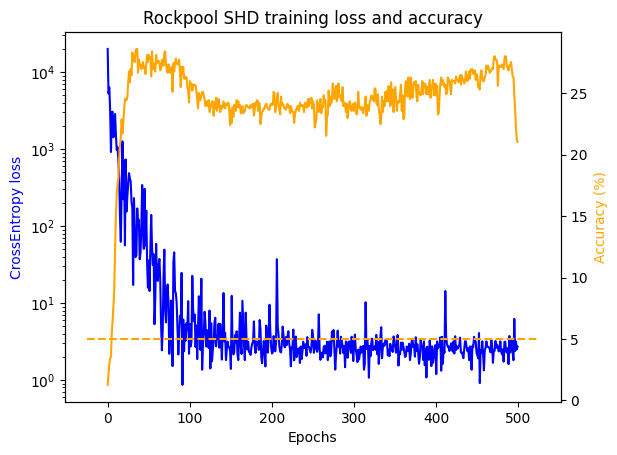

In [21]:
# - Plot the Training Loss
fig, ax = plt.subplots()
ax.plot(loss_t, color='blue')
ax.set_ylabel('CrossEntropy loss', color='blue')
ax.set_yscale('log')
ax.set_xlabel('Epochs')

ax2 = ax.twinx()
ax2.plot(accuracy, color='orange')
ax2.plot(ax2.get_xlim(), [100/20, 100/20], '--', color='orange')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.set_yscale('linear')

plt.title('Rockpool SHD training loss and accuracy')
plt.show()

In [22]:
# - Test loop:
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0

    for events, labels in test_loader:
        arr = np.array(labels, dtype=np.long)
            #print(arr)
        labels = torch.tensor(arr, dtype=torch.long)
        output, _, _ = net(torch.Tensor(events).float())

        sum = torch.cumsum(output, dim=1)

        predicted = torch.argmax(sum[:,-1,:], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy_test = (correct/total)*100

print(f"Test Accuracy: {accuracy_test:.3f}%")


Test Accuracy: 17.568%


In [23]:
torch.save(net.state_dict(), "modelSNN_NoNoise.pth")

Lets try with some noisy data

In [24]:
net_noisy = SimpleNet(Nin, Nhidden, Nout)
print(net_noisy)
optimizer = Adam(net_noisy.parameters().astorch(), lr=1e-3)

TorchSequential  with shape (16, 24) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    LinearTorch '2_LinearTorch' with shape (20, 20)
    LIFTorch '3_LIFTorch' with shape (20, 20)
    LinearTorch '4_LinearTorch' with shape (20, 24)
    ExpSynTorch '5_ExpSynTorch' with shape (24,)
}


In [28]:
zip_file_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/kitchen_spike_dataset_noisy.zip'
extract_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [29]:
dataset_path = '/content/drive/MyDrive/D7046E_SNN_project_dataset/kitchen_spike_dataset_noisy/sample_info.npy'
dataset = SpikeRasterDataset(dataset_path)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print("train set size:\t",train_size)
print("val set size:\t",val_size)
print("test set size:\t",test_size)
print("total size:\t",total_size)

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader_noisy = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader_noisy  = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader_noisy  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

train set size:	 1031
val set size:	 220
test set size:	 222
total size:	 1473


In [30]:
# Import tqdm to visualise training progress
from tqdm.autonotebook import tqdm
num_epochs=100
# - Training Loop
with tqdm(range(num_epochs), unit = 'Epoch', desc = 'Training') as pbar:
    for _ in pbar:
        correct = 0
        total_loss = 0
        total = 0
        temp_loss = 0

        net_noisy.train()

        for events, labels in train_loader_noisy:
            #events, labels = events.to(device), labels.to(device)
            # events = events.to_dense()

            arr = np.array(labels, dtype=np.long)
            #print(arr)
            labels = torch.tensor(arr, dtype=torch.long)
            #print(tensor)
            #print(tensor.dtype)

            optimizer.zero_grad()

            output, _, _ = net_noisy(events)

            sum = torch.cumsum(output, dim=1)

            loss = loss_fun(sum[:,-1,:], labels)

            loss.backward()
            optimizer.step()

            # Calculate the number of correct answers
            predicted = torch.argmax(sum[:,-1,:], 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            this_loss = loss.item()

        # - Keep track of the accuracy
        this_accuracy = (correct/total)*100
        accuracy.append(this_accuracy)
        loss_t.append(this_loss)
        pbar.set_postfix(Loss = f'{this_loss:.2f}', Accuracy = f'{this_accuracy:.0f}%')

print(f"Training Accuracy: {accuracy[-1]:.3f}%")

Training:   0%|          | 0/100 [00:00<?, ?Epoch/s]

Training Accuracy: 47.915%


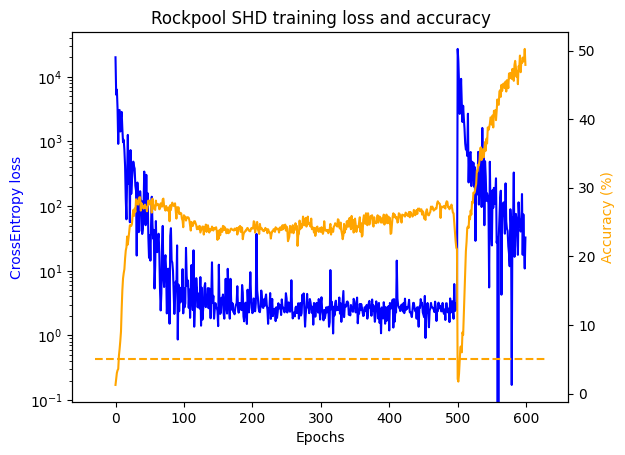

In [31]:
# - Plot the Training Loss
fig, ax = plt.subplots()
ax.plot(loss_t, color='blue')
ax.set_ylabel('CrossEntropy loss', color='blue')
ax.set_yscale('log')
ax.set_xlabel('Epochs')

ax2 = ax.twinx()
ax2.plot(accuracy, color='orange')
ax2.plot(ax2.get_xlim(), [100/20, 100/20], '--', color='orange')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.set_yscale('linear')

plt.title('Rockpool SHD training loss and accuracy')
plt.show()

In [32]:
# - Test loop:
net_noisy.eval()
with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0

    for events, labels in test_loader_noisy:
        arr = np.array(labels, dtype=np.long)
            #print(arr)
        labels = torch.tensor(arr, dtype=torch.long)
        output, _, _ = net_noisy(torch.Tensor(events).float())

        sum = torch.cumsum(output, dim=1)

        predicted = torch.argmax(sum[:,-1,:], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy_test = (correct/total)*100

print(f"Test Accuracy: {accuracy_test:.3f}%")

Test Accuracy: 47.748%
